# 4.2 Data Loader 작성

## 학습 목표
1. 마스크 데이터를 이해
2. OpenPose에서 사용하는 Dataset 클래스, dataloader 구현
3. openpose의 전처리 및 데이터 확장의 처리 이해

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# 필요한 패키지 import
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

# 화상, 마스크 화상, 어노테이션 데이터의 파일 경로 리스트를 작성

In [12]:
def make_datapath_list(rootpath):
    """
    학습 및 검증의 화상 데이터와 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트를 작성한다.
    """

    # 어노테이션의 JSON 파일을 읽기
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    # index를 저장
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    # 화상 파일 경로를 저장
    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # 마스크 데이터의 경로를 저장
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = os.path.join(rootpath + "mask/train2014/mask_COCO_train2014_" + img_idx + ".jpg")
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = os.path.join(rootpath + "mask/val2014/mask_COCO_val2014_" + img_idx + ".jpg")
        val_mask_list.append(anno_path)

    # 어노테이션 데이터를 저장
    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list


In [54]:
# 동작 확인
rootpath = "/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/data/"
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath = rootpath)


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


'val2014/COCO_val2014_000000000488.jpg'

In [55]:
val_meta_list[24]['img_paths']

'val2014/COCO_val2014_000000000488.jpg'

In [14]:
val_mask_list[24]

'/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/data/mask/val2014/mask_COCO_val2014_000000000488.jpg'

In [15]:
val_img_list[24]

'/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/data/val2014/COCO_val2014_000000000488.jpg'

# 마스크 데이터의 동작을 확인

In [16]:
val_mask_list[24]

'/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/data/mask/val2014/mask_COCO_val2014_000000000488.jpg'

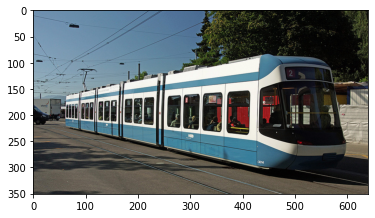

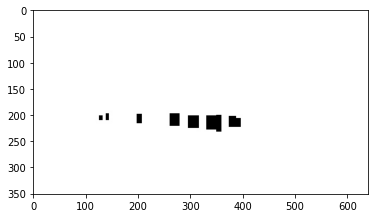

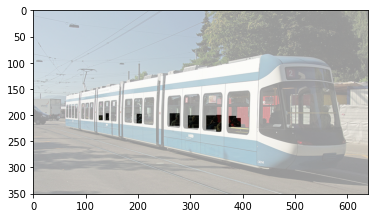

In [85]:
# 화상
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/data/val2014/COCO_val2014_000000006040.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()

# 화상 전처리
# colab에서 opencv 경로가 먹지 않을 경우 fromfile로 사용
mask_array = np.fromfile("/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/data/mask/val2014/mask_COCO_val2014_000000006040.jpg", np.uint8)
mask_miss = cv2.imdecode(mask_array, cv2.IMREAD_UNCHANGED)
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_RGB2BGR)
plt.imshow(mask_miss)
plt.show()

# 합성
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


# 화상전처리 작성

In [106]:
%cd "/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/"

/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)


In [107]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)'

In [110]:
# 데이터 처리 클래스와 데이터 확장 클래스를 import
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
    """
    화상과 마스크, 어노테이션의 전처리 클래스.
    학습시와 추론시에 서로 다르게 동작한다.
    학습시에는 데이터 확장을 수행한다.
    """

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                get_anno(),  # JSON에서 어노테이션을 사전에 저장
                add_neck(),  # 어노테이션 데이터의 순서를 변경하고, 목의 어노테이션 데이터를 추가
                aug_scale(),  # 확대 축소
                aug_rotate(),  # 회전
                aug_croppad(),  # 자르기
                aug_flip(),  # 좌우 반전
                remove_illegal_joint(),  # 화상에서 밀려나온 어노테이션을 제거
                # Normalize_Tensor()  # 색상 정보의 표준화 및 텐서화
                no_Normalize_Tensor()  # 여기서는 색상 정보의 표준화를 생략
            ]),
            'val': Compose([
                # 검증을 생략
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리의 모드를 지정.
        """
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)

        return meta_data, img, mask_miss

In [111]:
# 동작 확인
# 화상 읽기
index = 40
img_array = np.fromfile(val_img_list[index])
img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
mask_array = np.fromfile(val_mask_list[index])
mask_miss = cv2.imdecode(mask_array, cv2.IMREAD_UNCHANGED)
meta_data = val_meta_list[index]

# 화상 전처리
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

# 화상 표시
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# 마스크 표시
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 합성 RGB 정보 갖추기
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


ValueError: ignored

In [114]:
img
mask_miss
meta_data

{'annolist_index': 27.0,
 'bbox': [189.42, 30.26, 429.41, 428.34],
 'bbox_other': [209.87, 129.27, 307.8, 343.32],
 'dataset': 'COCO_val',
 'image_id': 692.0,
 'img_height': 480.0,
 'img_paths': 'val2014/COCO_val2014_000000000692.jpg',
 'img_width': 640.0,
 'isValidation': 1.0,
 'joint_others': [[327.0, 240.0, 1.0],
  [345.0, 217.0, 1.0],
  [304.0, 226.0, 1.0],
  [378.0, 215.0, 1.0],
  [282.0, 238.0, 1.0],
  [404.0, 274.0, 1.0],
  [296.0, 305.0, 1.0],
  [472.0, 335.0, 1.0],
  [284.0, 361.0, 1.0],
  [398.0, 319.0, 1.0],
  [251.0, 366.0, 1.0],
  [425.0, 417.0, 0.0],
  [360.0, 434.0, 0.0],
  [474.0, 420.0, 1.0],
  [319.0, 441.0, 0.0],
  [0.0, 0.0, 2.0],
  [0.0, 0.0, 2.0]],
 'joint_self': [[327.0, 237.0, 0.0],
  [342.0, 214.0, 0.0],
  [304.0, 224.0, 0.0],
  [376.0, 212.0, 0.0],
  [277.0, 229.0, 0.0],
  [392.0, 263.0, 0.0],
  [303.0, 301.0, 0.0],
  [470.0, 332.0, 0.0],
  [287.0, 362.0, 0.0],
  [400.0, 316.0, 0.0],
  [251.0, 367.0, 0.0],
  [421.0, 428.0, 1.0],
  [360.0, 445.0, 0.0],
  [476.0

In [96]:
print(val_img_list[40])
print(val_mask_list[40])
print(val_meta_list[40])

/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/data/val2014/COCO_val2014_000000000692.jpg
/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/4. 자세추정(OpenPose)/data/mask/val2014/mask_COCO_val2014_000000000692.jpg
{'dataset': 'COCO_val', 'isValidation': 1.0, 'img_paths': 'val2014/COCO_val2014_000000000692.jpg', 'img_width': 640.0, 'img_height': 480.0, 'objpos': [404.125, 244.43], 'image_id': 692.0, 'bbox': [189.42, 30.26, 429.41, 428.34], 'segment_area': 84122.971, 'num_keypoints': 15.0, 'joint_self': [[327.0, 237.0, 0.0], [342.0, 214.0, 0.0], [304.0, 224.0, 0.0], [376.0, 212.0, 0.0], [277.0, 229.0, 0.0], [392.0, 263.0, 0.0], [303.0, 301.0, 0.0], [470.0, 332.0, 0.0], [287.0, 362.0, 0.0], [400.0, 316.0, 0.0], [251.0, 367.0, 0.0], [421.0, 428.0, 1.0], [360.0, 445.0, 0.0], [476.0, 419.0, 0.0], [313.0, 453.0, 0.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0]], 'scale_provided': 1.164, 'joint_others': [[327.0, 240.0, 1.0

# 훈련 데이터의 정답 정보로써 사용하는 어노테이션 데이터 작성

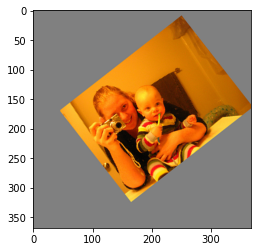

In [115]:
from utils.dataloader import get_ground_truth

# 화상 읽기
index = 40
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

# 화상 전처리
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPose의 어노테이션 데이터 생성
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 화상 표시
plt.imshow(img)
plt.show()

In [116]:
# 왼쪽 팔꿈치의 heatmap를 확인

# 원래 화상
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 주의: heatmap은 화상 크기가 1/8으로 되어 있으므로 확대한다

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: ignored

In [117]:
# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


TypeError: ignored

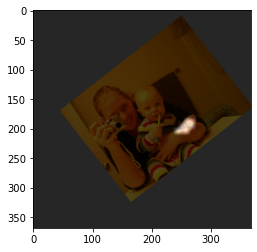

In [118]:
# 왼쪽 팔꿈치와 왼쪽 손목에 PAF를 확인
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()


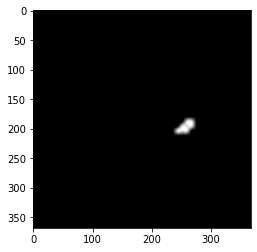

In [119]:
# PAF만 표시
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)


# Dataset 작성

In [120]:
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCO Cocokeypoints의 Dataset를 작성하는 클래스. PyTorch Dataset 클래스를 상속.

    Attributes
    ----------
    img_list : 리스트
        화상 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련을 설정.
    transform : object
        전처리 클래스의 인스턴스
    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''화상의 Tensor 형식 데이터, 어노테이션, 마스크를 취득한다'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]

        # 2. 마스크와 어노테이션 읽기
        mask_miss = cv2.imread(self.mask_list[index])
        meat_data = self.meta_list[index]

        # 3. 화상 전처리
        meta_data, img, mask_miss = self.transform(
            self.phase, meat_data, img, mask_miss)

        # 4. 정답 어노테이션 데이터 취득
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. 마스크 데이터는 RGB가 (1,1,1) 또는 (0,0,0)이므로, 차원을 낮춘다
        # 마스크된 위치는 값이 0, 그렇지 않으면 1입니다
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. 채널이 맨 끝에 있으므로, 순서를 변경
        # 예: paf_mask: torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask


In [121]:
# 동작 확인
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# 데이터 꺼내기 예
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


error: ignored

In [122]:
# 데이터 로더 작성
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복으로 변환
item = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


error: ignored